<a href="https://colab.research.google.com/github/mlwright84/bacgrowth/blob/main/Bacterial_Growth_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of Bacterial Growth

Matthew Wright and John Chase

April 2021

This notebook contains code for the simulations in our paper "Bacterial Growth: Not So Simple".



In [1]:
import math
import queue
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

## Exponentially distributed time-to-division

The following code simulates many populations with $\mathrm{Exp}(1)$ underlying splitting distribution and produces a plot like Figure 2 in the paper.

In [2]:
# function to simulate many bacteria populations, each of which has an Exp(1) underlying splitting distribution
# parameters:
#   numSims: number of populations to simulate
#   timeVals: list/array of increasing time values at which to record the population sizes
# returns:
#   popSizeDF: dataframe containing sizes of each population at each time value
#   splitTimeLists

def simulateManyPopulations(numSims, timeVals):
  # set up a dataframe to store the size of each population at each time
  popSizeDF = pd.DataFrame(columns = timeVals)

  # set up lists to store the splitting times for each population
  splitTimeLists = []

  # run simulations and record results in the intervals list
  for n in range(numSims):
    # list to track size of this population at each time index
    sizeAtTime = np.zeros(len(timeVals), dtype='int64')

    # list to track splitting times
    splitTimes = []

    # priority queue for times at which cells split
    splits = queue.PriorityQueue()

    # generate the splitting time of the first cell
    splits.put(random.expovariate(1))

    # population starts with 1 bacterium at time 0
    time = 0
    tIndex = 0
    size = 1
    
    # simulate bacteria splitting until max time index is reached
    while tIndex < len(timeVals):
      time = splits.get()	 # get the smallest time in the splits queue -- time that population reaches size
      size = size + 1      # this is the new population size
      splitTimes.append(time)
      
      # store size at indexes 
      while tIndex < len(timeVals) and timeVals[tIndex] < time:
        sizeAtTime[tIndex] = size - 1
        tIndex += 1
      
      # the current cell has split, creating two new splitting times in the queue
      r1 = random.expovariate(1)
      r2 = random.expovariate(1)
      splits.put(time + r1)
      splits.put(time + r2)

    # append rows
    popSizeDF.loc[n] = sizeAtTime.tolist()
    splitTimeLists.append(splitTimes)

  # return the dataframe
  return popSizeDF, splitTimeLists

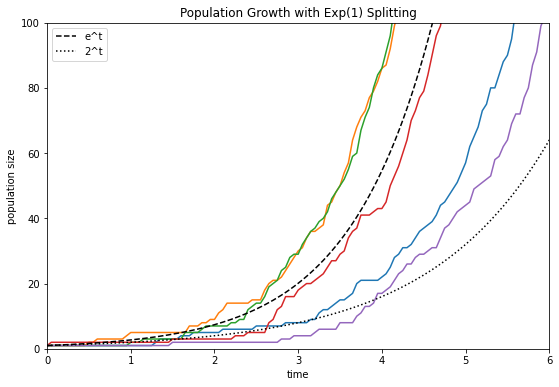

In [5]:
# run some simluations
timeVals = np.linspace(0,8,161)
popSizeDF, splitTimes = simulateManyPopulations(5, timeVals)

# print population curves from popSizeDF
(rows,cols) = popSizeDF.shape
plt.figure(figsize=(9,6))

for r in range(rows):
  yvals = popSizeDF.iloc[r,:]
  plt.plot(timeVals,yvals)

plt.plot(timeVals, np.exp(timeVals), 'k--', label='e^t')
plt.plot(timeVals, np.exp2(timeVals), 'k:', label='2^t')
plt.legend()

plt.xlim(0,6)
plt.ylim(0,100)

plt.title("Population Growth with Exp(1) Splitting")
plt.xlabel("time")
plt.ylabel("population size");

## Gamma distributed time-to-division

The following code simulates average population sizes when the underlying splitting distribution  is $\mathrm{Gamma}(\alpha, 1/\alpha)$ and produces a plot like Figure 3 in the paper.

In [6]:
# function to simulate a population until a stopping time
# this is used to randomize the "age" of the initial bacterium in a population
# parameters:
#   alpha: underlying splitting distribution is Gamma(alpha, 1/alpha)
#   stopTime: time at which the simulation stops
# returns: list of time-to-division for each bacterium alive at the stopping time
def simulatePopulationAtTime(alpha, stopTime):
  # priority queue for times at which cells split
  splits = queue.PriorityQueue()

  # population starts with 1 bacterium at time 0
  time = 0
  size = 1

  # generate the splitting time of the first cell
  # note: Gamma(k, 1/alpha) where k ~ DiscreteUniform[1, alpha]
  k = random.randint(1,alpha)
  splits.put(random.gammavariate(k,1/alpha)) 
    
  # simulate bacteria splitting until max time index is reached
  while time < stopTime:
    time = splits.get()	 # get the smallest time in the splits queue -- time that population reaches size
  
    # the current cell has split, creating two new splitting times in the queue,
    #   determined by the underlying distribution
    r1 = random.gammavariate(alpha, 1/alpha)
    r2 = random.gammavariate(alpha, 1/alpha)
    splits.put(time + r1)
    splits.put(time + r2)

  # convert queue to a list of times until next splits for all currently-alive cells
  nextSplits = []
  while not splits.empty():
    t = splits.get() - stopTime
    nextSplits.append(t)

  return nextSplits

# function to simulate average size of many bacteria populations
# uses simulatePopulationAtTime() to choose the time at which the first bacterium splits (if alpha > 1)
# parameters:
#   numSims: number of populations to simulate
#   alpha: underlying splitting distribution is Gamma(alpha, 1/alpha)
#   timeVals: list/array of increasing time values at which to record the population sizes
# returns: average population size at each time value

def simulateAvgPopSizesRandomInitialAge(numSims, alpha, timeVals):
  # list for average population size at each time index
  avgSizeAtTime = np.zeros(len(timeVals))

  # run simulations and record results in the intervals list
  for n in range(numSims):
    # list to track size of this population at each time index
    sizeAtTime = np.zeros(len(timeVals))

    # priority queue for times at which cells split
    splits = queue.PriorityQueue()

    # population starts with 1 bacterium at time 0
    time = 0
    tIndex = 0
    size = 1

    # generate the splitting time of the first cell
    if alpha == 1:
      splits.put(random.expovariate(1))  # since exponential distribution is memoryless
    else:
      startingDistribution = simulatePopulationAtTime(alpha, 8)   # do the pre-simulation, then
      splits.put( random.choice(startingDistribution) )           # choose a random bacterium
    
    # simulate bacteria splitting until max time index is reached
    while tIndex < len(timeVals):
      time = splits.get()	 # get the smallest time in the splits queue -- time that population reaches size
      size = size + 1      # this is the new population size
      
      # store size at indexes 
      while tIndex < len(timeVals) and timeVals[tIndex] < time:
        sizeAtTime[tIndex] = size - 1
        tIndex += 1
      
      # the current cell has split, creating two new splitting times in the queue,
      #  determined by the underlying distribution
      r1 = random.gammavariate(alpha, 1/alpha)
      r2 = random.gammavariate(alpha, 1/alpha)
      splits.put(time + r1)
      splits.put(time + r2)

    # add population sizes to master list
    avgSizeAtTime = avgSizeAtTime + sizeAtTime

  # return the average sizes at each time
  return avgSizeAtTime/numSims

In [7]:
# this code simulates average population sizes at each of the following time values,
#   where underlying splitting distribution is Gamma(alpha, 1/alpha) for each of the following alpha values
alphaVals = [1,2,3,10,30,100]
timeVals = np.linspace(0, 10, 201)
numPopulations = 10000

rowList = []

for a in alphaVals:
  yvals = simulateAvgPopSizesRandomInitialAge(numPopulations, a, timeVals)
  rowList.append(yvals)
  print("finished α =", a)

# show a dataframe containing the results of the simulation
colNames = [f"t={t:.2f}" for t in timeVals]
alphaLabels = ["α = "+str(int(a)) for a in alphaVals]
avgPopSizeDF = pd.DataFrame(rowList, columns = colNames, index=alphaLabels)
pd.set_option('display.max_columns', None)
avgPopSizeDF

finished α = 1
finished α = 2
finished α = 3
finished α = 10
finished α = 30
finished α = 100


,t=0.00,t=0.05,t=0.10,t=0.15,t=0.20,t=0.25,t=0.30,t=0.35,t=0.40,t=0.45,t=0.50,t=0.55,t=0.60,t=0.65,t=0.70,t=0.75,t=0.80,t=0.85,t=0.90,t=0.95,t=1.00,t=1.05,t=1.10,t=1.15,t=1.20,t=1.25,t=1.30,t=1.35,t=1.40,t=1.45,t=1.50,t=1.55,t=1.60,t=1.65,t=1.70,t=1.75,t=1.80,t=1.85,t=1.90,t=1.95,t=2.00,t=2.05,t=2.10,t=2.15,t=2.20,t=2.25,t=2.30,t=2.35,t=2.40,t=2.45,t=2.50,t=2.55,t=2.60,t=2.65,t=2.70,t=2.75,t=2.80,t=2.85,t=2.90,t=2.95,t=3.00,t=3.05,t=3.10,t=3.15,t=3.20,t=3.25,t=3.30,t=3.35,t=3.40,t=3.45,t=3.50,t=3.55,t=3.60,t=3.65,t=3.70,t=3.75,t=3.80,t=3.85,t=3.90,t=3.95,t=4.00,t=4.05,t=4.10,t=4.15,t=4.20,t=4.25,t=4.30,t=4.35,t=4.40,t=4.45,t=4.50,t=4.55,t=4.60,t=4.65,t=4.70,t=4.75,t=4.80,t=4.85,t=4.90,t=4.95,t=5.00,t=5.05,t=5.10,t=5.15,t=5.20,t=5.25,t=5.30,t=5.35,t=5.40,t=5.45,t=5.50,t=5.55,t=5.60,t=5.65,t=5.70,t=5.75,t=5.80,t=5.85,t=5.90,t=5.95,t=6.00,t=6.05,t=6.10,t=6.15,t=6.20,t=6.25,t=6.30,t=6.35,t=6.40,t=6.45,t=6.50,t=6.55,t=6.60,t=6.65,t=6.70,t=6.75,t=6.80,t=6.85,t=6.90,t=6.95,t=7.00,t=7.05,t=7.10,t=7.15,t=7.20,t=7.25,t=7.30,t=7.35,t=7.40,t=7.45,t=7.50,t=7.55,t=7.60,t=7.65,t=7.70,t=7.75,t=7.80,t=7.85,t=7.90,t=7.95,t=8.00,t=8.05,t=8.10,t=8.15,t=8.20,t=8.25,t=8.30,t=8.35,t=8.40,t=8.45,t=8.50,t=8.55,t=8.60,t=8.65,t=8.70,t=8.75,t=8.80,t=8.85,t=8.90,t=8.95,t=9.00,t=9.05,t=9.10,t=9.15,t=9.20,t=9.25,t=9.30,t=9.35,t=9.40,t=9.45,t=9.50,t=9.55,t=9.60,t=9.65,t=9.70,t=9.75,t=9.80,t=9.85,t=9.90,t=9.95,t=10.00
α = 1,1.0,1.0514,1.1076,1.1622,1.2200,1.2817,1.3463,1.4184,1.4897,1.5638,1.6426,1.7221,1.8166,1.9101,2.0052,2.1046,2.2125,2.3243,2.4405,2.5625,2.6862,2.8180,2.9587,3.1154,3.2757,3.4383,3.6178,3.8050,4.0044,4.2057,4.4163,4.6365,4.8846,5.1346,5.3942,5.6745,5.9681,6.2721,6.5943,6.9326,7.2754,7.6441,8.0302,8.4428,8.8691,9.3307,9.8043,10.3045,10.8419,11.4101,11.9887,12.5931,13.2373,13.9264,14.6506,15.4165,16.1939,17.0322,17.9130,18.8462,19.7937,20.7903,21.8573,22.9896,24.1508,25.4102,26.6944,28.0653,29.4966,30.9870,32.5743,34.2405,36.0263,37.8952,39.8583,41.9090,44.0650,46.3286,48.7178,51.2341,53.8304,56.5988,59.5153,62.5538,65.7941,69.1642,72.7473,76.4439,80.3486,84.4506,88.7824,93.3530,98.1563,103.1656,108.4932,114.0806,119.8918,126.0120,132.4685,139.3038,146.4492,153.9639,161.8616,170.1581,178.8964,188.0991,197.7020,207.8475,218.4847,229.6637,241.5076,253.8857,266.8894,280.5898,294.9800,310.1263,325.9902,342.6846,360.2797,378.7224,398.1841,418.7112,440.1885,462.7826,486.4879,511.4141,537.6738,565.2237,594.2321,624.6851,656.7440,690.4455,725.8122,762.9111,802.1315,843.2312,886.4390,931.9532,979.7212,1029.9296,1082.7109,1138.2247,1196.6128,1257.8630,1322.4181,1390.1472,1461.3944,1536.2575,1615.0231,1697.7983,1784.6647,1876.1713,1972.4933,2073.6078,2179.8898,2291.5664,2409.0293,2532.5723,2662.3427,2798.5536,2941.9837,3092.8499,3251.6191,3418.2763,3593.4817,3777.6990,3971.5254,4174.9635,4388.8737,4613.8843,4850.5095,5099.0124,5360.5483,5635.5603,5924.7625,6228.2520,6547.6301,6883.1559,7236.3223,7607.3100,7997.1309,8407.0545,8838.0011,9291.3353,9767.8820,10268.9896,10795.3903,11348.6101,11930.5008,12542.0623,13185.0031,13860.6458,14571.3094,15318.5545,16103.9996,16929.4693,17797.2913,18710.0429,19669.2433,20677.6758,21737.7252
α = 2,1.0,1.0409,1.0848,1.1291,1.1745,1.2248,1.2775,1.3320,1.3902,1.4486,1.5097,1.5694,1.6375,1.7063,1.7796,1.8588,1.9415,2.0285,2.1133,2.1975,2.2875,2.3827,2.4894,2.5939,2.7073,2.8222,2.9433,3.0692,3.2053,3.3390,3.4791,3.6341,3.7903,3.9449,4.1023,4.2760,4.4511,4.6373,4.8322,5.0299,5.2474,5.4737,5.7101,5.9462,6.2004,6.4631,6.7392,7.0204,7.3309,7.6306,7.9568,8.2970,8.6468,9.0120,9.3900,9.7884,10.2131,10.6465,11.0919,11.5677,12.0569,12.5774,13.1081,13.6719,14.2436,14.8514,15.4770,16.1190,16.7986,17.5218,18.2601,19.0288,19.8313,20.6712,21.5440,22.4482,23.3847,24.3654,25.4012,26.5047,27.6159,28.7671,29.9745,31.2400,32.5717,33.9500,35.3892,36.8915,38.4515,40.0878,41.7733,43.5369,45.3576,47.2833,49.2929,51.3727,53.5229,55.7810,58.1537,60.5955,63.1638,65.8255,68.6228,71.5375,74.5583,77.7308,81.0091,84.4454,88.0189,91.7471,95.6221,99.656

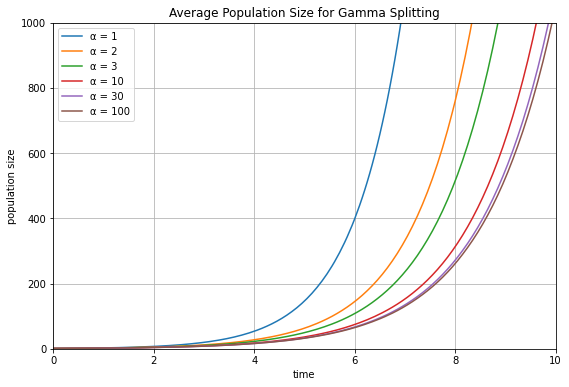

In [8]:
# plot the average population size functions from the simulation
(rows,cols) = avgPopSizeDF.shape

plt.figure(figsize=(9,6))
plt.grid(color='0.7')
for r in range(rows): 
  yVals = avgPopSizeDF.iloc[r,:]
  plt.plot(timeVals, yVals)

plt.xlim(0,10)
plt.ylim(0, 1000)

plt.title("Average Population Size for Gamma Splitting")
plt.xlabel("time")
plt.ylabel("population size")
plt.legend(["α = "+str(int(a)) for a in alphaVals]);

We now fit curves to the average population size data above. In the next code cell, we compute linear regressions on the log of the average population sizes over time.

In [9]:
# compute exponential regression
(rows,cols) = avgPopSizeDF.shape
yvals = [math.log(y) for y in range(1,cols)]

rowList = []
for r in range(rows):
  slope, intercept, rval, pval, stderr = stats.linregress(timeVals, np.log(avgPopSizeDF.iloc[r,:]))
  rowList.append([slope, math.exp(slope), intercept, math.exp(intercept), rval])

# display the regression data in a table
alphaLabels = ["α = "+str(int(a)) for a in alphaVals]
colLabels = ["slope","exp(slope)","intercept","exp(intercept)","correlation"]
regDF = pd.DataFrame(rowList, columns=colLabels, index=alphaLabels)
regDF

,slope,exp(slope),intercept,exp(intercept),correlation
α = 1,0.999632,2.717281,-0.010873,0.989186,0.999999
α = 2,0.828822,2.290618,0.001275,1.001276,1.000000
α = 3,0.780372,2.182284,-0.000902,0.999098,1.000000
α = 10,0.717940,2.050206,0.002030,1.002032,1.000000
α = 30,0.701343,2.016459,-0.007551,0.992477,1.000000
α = 100,0.695541,2.004794,-0.000277,0.999723,1.000000


In the next code cell, we use `scipy.optimize.curve_fit` to fit a function $f(t) = r^t$ to the average population sizes over time. This produces regression functions like those in Table 1 in the paper.

In [10]:
# exponential regression f(t) = 1 r^t
def f_rt(t, r):
  return r**t

(rows,cols) = avgPopSizeDF.shape
rvals = [0]*6
for r in range(rows):
  popt, pcov = curve_fit(f_rt, timeVals, avgPopSizeDF.iloc[r,:])
  rvals[r] = popt[0]
  print("r = ",popt[0])
  print("variance of estimate:", pcov[0,0])

r =  2.714535051152477
variance of estimate: 1.7729954517697125e-10
r =  2.2906405508944667
variance of estimate: 3.040498844771594e-11
r =  2.181879965310666
variance of estimate: 1.9406024775176035e-11
r =  2.0505840831477937
variance of estimate: 9.316995222451666e-12
r =  2.014788890198907
variance of estimate: 6.614218590863755e-11
r =  2.004743228515968
variance of estimate: 3.000973889998387e-11


## Asymptotics

The following code simulates the ratio $Z(t)/b^2$, where $Z(t)$ is the aggregate population growth function and $b$ is the aggregate growth factor. Computing this ratio for a large number of simulations, we obtain a figure like Figure 4 in the paper.

In [11]:
# simulate population growth until a specified stopping time
# parameters:
#   stopTime: time at which the simulation stops
#   alpha: underlying splitting distribution is Gamma(alpha, 1/alpha)
# returns: population size at the stopping time

def simulateSizeAtTime(stopTime, alpha):
  # priority queue for times at which cells split
  splits = queue.PriorityQueue()

  #population starts with 1 bacterium at time 0
  time = 0
  size = 1

  # generate the splitting time of the first cell
  if alpha == 1:
    splits.put(random.expovariate(1))  # since exponential distribution is memoryless
  else:
    startingDistribution = simulatePopulationAtTime(alpha, 8)   # do the pre-simulation, then
    splits.put( random.choice(startingDistribution) )           # choose a random bacterium
    
  # simulate bacteria splitting until stopTime is reached
  while time < stopTime:
    time = splits.get()	 # get the smallest time in the splits queue -- time that population reaches size
    size = size + 1      # this is the new population size
      
    # the current cell has split, creating two new splitting times in the queue,
    #  determined by the underlying distribution
    r1 = random.gammavariate(alpha, 1/alpha)
    r2 = random.gammavariate(alpha, 1/alpha)
    splits.put(time + r1)
    splits.put(time + r2)

  return size

mean ratio is: 1.0070838641745457


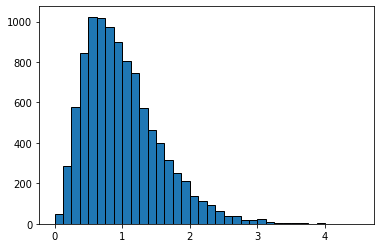

In [12]:
# now simulate 10,000 populations with Gamma(3, 1/3) underlying splitting distribution
finalSizes = np.array([simulateSizeAtTime(8,3) for _ in range(10000)])

# aggregregate growth factor for Gamma(3, 1/3)
b = 2.18095564

ratios = finalSizes/(b**8)
print("mean ratio is:",np.mean(ratios))

counts, bins, patches = plt.hist(ratios, range=(0,4.5), bins=36, edgecolor='black')